# Topics in Applied Optimization (IIIT, Hyderabad, India)
# Jupyter Notebook Assignment-3 
### Instructor: Dr. Pawan Kumar (IIIT, H) (https://faculty.iiit.ac.in/~pawan.kumar/)
If you are not familiar with Jupyter notebook, before proceeding further, please go and watch this video:

https://www.youtube.com/watch?v=HW29067qVWk

## Regarding assignments
### Deadline: 13 October 2019 (or 20 Oct with 15% penalty)
- all the assignment is to be done in this notbook itself
- any proof etc can be done on paper, and image is to be inserted in this notebook
- save this notebook with your roll number and upload it in moodle
- basic familiarity with python is required, brush up if necessary
- you are not allowed to use any existing library for gradient methods; this defeats the purpose of this assignment
- sample output is in the zip file of assignment
- if there are any doubt, then raise it in course moodle site, it may help others
- if you find typo, raise this issue in moodle promptly!
- please avoid copying from others, there may be oral exam to test your knowledge

## 0. Setup and Prerequisites
To run this notebook, you will need the following libraries:
- `numpy`
- `matplotlib`
- `pandas` (for the bonus question)

You can install them via pip:
```bash
pip install numpy matplotlib pandas
```


# Implementation of Recommender System Using Latent Factor Model in Python

Please refer to the class slides for more detail. Also, for full detail, please refer the following main reference:

**[1] Y. Koren, R. Bell, and C. Volinsky, Matrix Factorization Techniques for Recommender Systems, Computer Archive, Volume 42, Issue 8, 2009** 

We first load the necessary libraries: 
1. matplotlib: needed for plotting figures and 
2. numpy needed for doing math

In [6]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Now we write the main functions

We write everything inside a class LF, which stands for latent factor. We need the following functions:
1. main
2. train
3. mse
4. sgd
5. predict
6. full_matrix

# Short Tutorial on Recommender Systems
Please see lecture slides for more detail.

## Latent Factor Model
In a recommender systems, we are given an incomplete ratings matrix say R. The $(i,j)$ entry of this matrix is denoted by $r_{ij}.$ 
- We believe that there are dependencies in the matrix, i.e., the matrix is low rank, hence it can be written as a product of low rank matrices. 
- Even if the matrix is not strictly low rank, we believe that certain features are more important than others. In other words, if the ratings matrix were full, then after doing SVD, we get 
$$R = U S V^T$$
some of the singular values were very small, hence the matrix can be approximated well with truncated SVD. Let us consider the first $k$ largest singular vectors, then the truncated SVD is 
$$R \approx U_k S_k V_k.$$
- See IPSC notes for more detail on how to compute SVD or truncated SVD
- For a recomendation problem, for example, movie recomendation or news recommendation or product recommendation, etc, we believe that certain latent features are most important and play a major role in ratings.
- For movie recommendation, for example, latent factors could be comedy, adventure, horror, etc. These features are called latent, because the given data, which is ratings matrix does not explicitely tells about these.
- For recommendation systems, we cannot do SVD, because the matrix $R$ is incomplete! Obviously, we cant treat the missing entries to be zero! Hence, instead of doing SVD, we will consider an error function that consider only the ratings that are given. Let us assume that the ratings matrix can be modelled as a latent factors, i.e., suppose that $$R = PQ, \quad P \in \mathbb{R}^{n \times k}, Q \in \mathbb{R}^{k \times n},$$ then the given rating $$r_{ij} = p_{i*}q_{*j},$$ where $p_{i*}$ denotes the $i$th row of $P,$ and $q_{*j}$ denotes the $j$th column of $Q.$


## Optimization Model
- As mentioned above, we cannot directly do SVD, however, we can indeed create a **loss function** as follows:
$$\mathcal{L}(p_{1*}, p_{2*}, \dots p_{n*}, q_{*1}, q_{*2}, \dots, q_{*n}) = \sum_{(i,j) \in K} (r_{ij} - p_{i*}q_{*j}).$$
- Note above that we see loss function as a function the variables $p_{1*}, p_{2*}, \dots, p_{*n},$ which are row vectors of $P,$ and as the column vectors of $Q,$ which are $q_{*1}, q_{*2}, \dots, q_{*n}.$ This allows us to **vectorize**. Why vectorize?
- In machine learning the weights and their combinations with the given data creates a model. In this case, the model is $PQ.$ Since the $k,$ is a hyperparameter, it is likely that one may choose $P$ and $Q$ to have too many columns, i.e., too many weights are used, this will lead to a large model, and hence leading to **overfitting**. 
If you are not familiar with overfitting, then pause here, and see the video here:

https://www.youtube.com/watch?v=u73PU6Qwl1I

    - What did you learn from video? 
    - What is termed as model? 
    - What is the meaning of model being large? 
    - What is the difference between linear and logistic regression? 
    - What is underfitting? 
    - What is a bias? 
    - How do you characterize bias and variance using terms overfitting or underfitting?

- A well known way to avoid overfitting is to do regularizations, by penalizing **large model** size. Let us modify our loss function as follows:
$$\mathcal{L}(\cdot) = \sum_{(i,j) \in K} (r_{ij} - p_{i*}q_{*j})^2 + \gamma/2 (\| P \|_F^2 + \| Q \|_F^2)$$
    - We have added the term $\gamma/2(\| P \|_F^2 + \| Q \|_F^2).$ It is called **regularization term**
    - The parameter $\gamma$ is called the **regularization parameter**
    - High $\gamma$ would mean that we don't want big model size; this may help prevent overfitting
- Let $e_{ij}$ denote the error corresponding to each $(ij)$ term, 
$$e_{ij} = r_{ij} - \sum_{s=1}^k p_{is}q_{sj}$$
then let us define the new error term $\tilde{e}$
$$\tilde{e}_{ij} = e_{ij}^2 + \gamma/2 (\|P\|_F^2 + \| Q \|_F^2),$$ 
that is,
$$\tilde{e}_{ij} = (r_{ij} - \sum_{s=1}^{k} p_{is}q_{sj} )^2 + \frac{\gamma}{2} (\|P\|_F^2 + \| Q \|_F^2)$$
- Note that $$\mathcal{L}(\cdot) = \sum_{(i,j) \in \mathcal{K}} \tilde{e}_{ij},$$
where $\mathcal{K}$ is the set of all indices for which ratings $r_{ij}$ are available.


## Gradient Method Versus Stochastic Gradient Methods
Following notes are taken from 
https://en.wikipedia.org/wiki/Stochastic_gradient_descent

For large dataset, $k$ and $n$ tend to be large, and computing gradient fully becomes too demanding. In machine learning or statistical estimation, we are usually required to find minimum of the loss functions of the form 
$$Q(w) = 1/n \sum_{j=1}^n Q_j (w)$$
That is loss function as "additive" decomposition. In other words, the loss function is a sum of the loss function where the sum is over the data samples. If $n$ is large, then computing full gradient is computationally demanding. However, if we indeed decide to run the gradient method. Then we recall the following steps:
1. Take initial random weight (possibly random and normally distributed between 0 and 1): $w^0$
2. $w^{i+1} = w^i - \alpha \nabla Q(w^i), \quad i=0, \dots$

Here the gradient $\nabla Q$ is the full gradient in the sense that
\begin{align}
\nabla Q(w) = \sum_{i=1}^n \nabla_{w}Q_i(w). \label{grad} \tag{1}
\end{align}

Here
\begin{align}
\nabla_w Q_i (w) = \begin{bmatrix}
\dfrac{\partial Q_i (w)}{\partial w_1} \\
\dfrac{\partial Q_i (w)}{\partial w_1} \\
\vdots \\
\dfrac{\partial Q_i (w)}{\partial w_n} \\
\end{bmatrix}  \label{grad2} \tag{2}
\end{align}

### Stochastic gradient  descent method
Stochastic gradient merthod, in short, SGD is a method (not necessarily descent due to stochasticity, but in expectation is usually is a descent), where the gradient is computed partially. For example, instead of summing for all $i=1...n,$ we can take a random sample, say $j_1,$ and do the update only for this sample as follows:
$$\nabla Q(w) = \nabla_{w}Q_{j_1}(w),$$
that is we have picked just one of the term i.e., $j_1$th term from \eqref{grad}.
Then the SGD update is:
$$w^{i+1} = w^i - \alpha \nabla Q_{j_1}(w^i), \quad i=0, \dots$$
Note that we could have taken few more terms in the sum, and would have updated for a batch. This is called, batched stochastic gradient descent.
It sounds incorrect, isnt it? Why such method may converge? With some basic assumption on the loss function, we can prove some convergence in expectance. More on convergence theory in class!

$\color{red}{\text{Question-0:}}$ Compute the full gradient of the loss function for recommendation system

$\color{red}{\text{Answer:}}$

The loss function for the recommender system with regularization is:
$$\mathcal{L}(\cdot) = \sum_{(i,j) \in \mathcal{K}} (r_{ij} - p_{i*}q_{*j})^2 + \frac{\gamma}{2} \left(\| P \|_F^2 + \| Q \|_F^2\right)$$

Let $e_{ij} = r_{ij} - \sum_{s=1}^{k} p_{is}q_{sj}$ denote the prediction error for user $i$ and item $j$.

**Gradient with respect to $p_{is}$:**

$$\frac{\partial \mathcal{L}}{\partial p_{is}} = \frac{\partial}{\partial p_{is}} \left[ \sum_{(i,j) \in \mathcal{K}} e_{ij}^2 + \frac{\gamma}{2} \|P\|_F^2 + \frac{\gamma}{2} \|Q\|_F^2 \right]$$

Since $e_{ij} = r_{ij} - \sum_{s=1}^k p_{is}q_{sj}$, we have $\frac{\partial e_{ij}}{\partial p_{is}} = -q_{sj}$.

Also, $\frac{\partial}{\partial p_{is}} \frac{\gamma}{2} \|P\|_F^2 = \gamma p_{is}$ (since $\|P\|_F^2 = \sum_{a,b} p_{ab}^2$).

Therefore:
$$\frac{\partial \mathcal{L}}{\partial p_{is}} = \sum_{j:(i,j)\in\mathcal{K}} 2 e_{ij} \cdot (-q_{sj}) + \gamma p_{is} = -2 \sum_{j:(i,j)\in\mathcal{K}} e_{ij} q_{sj} + \gamma p_{is}$$

**Gradient with respect to $q_{sj}$:**

Similarly, $\frac{\partial e_{ij}}{\partial q_{sj}} = -p_{is}$ and $\frac{\partial}{\partial q_{sj}} \frac{\gamma}{2} \|Q\|_F^2 = \gamma q_{sj}$.

$$\frac{\partial \mathcal{L}}{\partial q_{sj}} = -2 \sum_{i:(i,j)\in\mathcal{K}} e_{ij} p_{is} + \gamma q_{sj}$$

**Full gradient vector:**

$$\nabla \mathcal{L} = \left(\frac{\partial \mathcal{L}}{\partial p_{11}}, \dots, \frac{\partial \mathcal{L}}{\partial p_{nk}}, \frac{\partial \mathcal{L}}{\partial q_{11}}, \dots, \frac{\partial \mathcal{L}}{\partial q_{kn}} \right)$$

**Vectorized form for stochastic update** (sampling one $(i,j)$ pair):

$$\nabla_{p_{i*}} \tilde{e}_{ij} = -2 e_{ij} q_{*j}^T + \gamma p_{i*}$$
$$\nabla_{q_{*j}} \tilde{e}_{ij} = -2 e_{ij} p_{i*}^T + \gamma q_{*j}$$

In the following, we derive a stochastic gradient for the loss function for recommender loss.

## Gradient Method for Optimization Problem
- We want to use gradient method to minimize the error. An update in gradient method is given as follows
$$w^{i+1} = w^i - \nabla \mathcal{L}(w^i)$$
- To use gradient method, we need to compute gradient. If we see $\mathcal{L}$ as a function of $p_{ik}'$s and $q_{ki}'$s, then 
$$\dfrac{\partial \mathcal{L}}{\partial p_{is}} = 2e_{is} \dfrac{\partial e_{is}}{\partial p_{is}} + \gamma p_{is} = -2e_{is} q_{sj} + \gamma p_{is}$$
Similarly,
$$\dfrac{\partial \mathcal{L}}{\partial q_{sj}} = 2e_{sj} \dfrac{\partial e_{sj}}{\partial q_{sj}}+\gamma q_{sj} = -2e_{sj}p_{js} + \gamma q_{sj},$$
- The gradient vector $\nabla \mathcal{L}$ is given by
$$\nabla \mathcal{L} = \left(\dfrac{\partial \mathcal{L}}{\partial p_{11}}, \dots, \dfrac{\partial \mathcal{L}}{\partial p_{nk}}, \dfrac{\partial \mathcal{L}}{\partial q_{11}}, \dots, \dfrac{\partial \mathcal{L}}{\partial p_{kn}} \right)$$
- The weights $p_{is}$ can be updated as
$$p_{is} = p_{is} + \alpha (2e_{ij} q_{sj} - \gamma p_{is}) $$
- The weights $p_{sj}$ can be updated as
$$q_{sj} = q_{sj} + \alpha (2e_{ij} p_{js} - \gamma q_{sj}) $$
- We can vectorize $s.$ Finally, the vectorized form of the update looks like:
$$(p_{i+1*}, q_{*j+1})^T = (p_{i*}, q_{*j})^T + \alpha ((2e_{ij} q_{*j} - \gamma p_{i*}), (2e_{ij} p_{j*} - \gamma q_{*j}))^T  $$
- The error at $(p_{i*}, q_{*j})^T$ nedded above can be computed by $$e_{ij} =  r_{ij} - \text{prediction at}~ (i,j) $$
Here prediction at $(i,j)$ can be computed by making a call to predict() function below.

$\color{red}{\text{Question-1:}}$ Why the error is computed this way?

$\color{red}{\text{Answer:}}$

The error is computed as $e_{ij} = r_{ij} - p_{i*}q_{*j}$ because it represents the residual between the actual known rating $r_{ij}$ and the predicted rating $\hat{r}_{ij} = p_{i*}q_{*j}$.

The loss function is a sum of squared errors over the **known** entries only (i.e., $(i,j) \in \mathcal{K}$). This is because:

1. **Only known ratings provide information**: We cannot compute error on missing entries since we don't know the true values. The purpose of the model is to predict these missing entries.

2. **Squared error is differentiable**: The squared error $e_{ij}^2$ is a smooth, differentiable function of the parameters $p_{is}$ and $q_{sj}$, which is required for gradient-based optimization methods.

3. **Convexity in individual terms**: While the overall loss function is non-convex (due to the bilinear product $PQ$), each squared error term $e_{ij}^2$ is a well-behaved function that allows computation of meaningful gradients.

4. **Regularization prevents overfitting**: The regularization term $\frac{\gamma}{2}(\|P\|_F^2 + \|Q\|_F^2)$ penalizes large model weights, preventing the model from perfectly fitting noise in the training data.

The gradient descent update uses $e_{ij}$ (not $e_{ij}^2$) because when we differentiate $e_{ij}^2$ with respect to the parameters, the chain rule produces a factor of $2 e_{ij}$, which is exactly what appears in the update rules.

$\color{red}{\text{Question-2:}}$ Are the updates for $p_{i*}$ and $q_{*j}$ stochastic? Justify.

$\color{red}{\text{Answer:}}$

Yes, the updates for $p_{i*}$ and $q_{*j}$ in the `sgd()` method are **stochastic**. This is because:

1. **Random sampling**: Before each iteration, the list of training samples is randomly shuffled using `np.random.shuffle(self.samples)`. This means the order in which $(i, j, r_{ij})$ triples are processed is random at each epoch.

2. **Per-sample updates**: Instead of computing the full gradient $\nabla \mathcal{L}$ over all known ratings in $\mathcal{K}$ (as in equation $\eqref{grad}$), the SGD method updates the parameters after each **single** training sample $(i, j, r_{ij})$. The gradient used is $\nabla \tilde{e}_{ij}$ — the gradient of the loss for just one $(i,j)$ pair — rather than the sum over all pairs.

3. **Noisy gradient estimate**: Each individual update uses a stochastic (noisy) approximation of the true gradient. In expectation (averaging over random sample choices), the stochastic gradient equals the full gradient, i.e., $\mathbb{E}[\nabla \tilde{e}_{ij}] \propto \nabla \mathcal{L}$. This is sufficient for convergence under standard assumptions.

In contrast, **full gradient descent** (`gd()`) computes the gradient over **all** known ratings before making a single parameter update. SGD is preferred for large datasets because it is computationally cheaper per iteration and often converges faster in practice.

# Adding Bias
It is often observed in practice that adding a bias term helps. Let us add the bias term $b$ to the prediction function. The bias term is computed as the mean of the ratings matrix. See the predict function below to see how bias is added.

$\color{red}{\text{Question-2b:}}$ Read the main reference paper and justify why bias is added. Note in this notebook we add global bias. Which other bias term was suggested in the paper?

$\color{red}{\text{Answer:}}$

According to Koren, Bell, and Volinsky [1], bias terms are added because much of the observed variation in ratings is due to effects associated with individual users or items (known as biases or intercepts), rather than true user-item interactions.

For example:
- Some users tend to rate all items higher (generous raters), while others rate lower (strict raters).
- Some items are generally rated higher (popular movies) and some lower (unpopular movies).

The paper suggests the following prediction model with bias:
$$\hat{r}_{ij} = \mu + b_u + b_i + p_{i*}q_{*j}$$

where:
- $\mu$ is the **global bias** (overall mean rating), denoted `self.b` in our code
- $b_u$ is the **user bias** for user $u$ (how much user $u$ deviates from the average)
- $b_i$ is the **item bias** for item $i$ (how much item $i$ deviates from the average)
- $p_{i*}q_{*j}$ captures the user-item interaction via latent factors

In this notebook, we currently add only the global bias $\mu$. The paper additionally recommends adding **user-specific bias** $b_u$ and **item-specific bias** $b_i$, which are learned alongside $P$ and $Q$ during training. These bias terms are also regularized in the loss function:
$$\mathcal{L}(\cdot) = \sum_{(i,j) \in \mathcal{K}} (r_{ij} - \mu - b_u - b_i - p_{i*}q_{*j})^2 + \frac{\gamma}{2} \left(\|P\|_F^2 + \|Q\|_F^2 + \sum_u b_u^2 + \sum_i b_i^2\right)$$

In [7]:
class LF():

    def __init__(self, R, K, alpha, gamma, iterations, use_bias=True, use_user_item_bias=False):
        """
        Parameters:
        - R (ndarray)            : user-item rating matrix
        - K (int)                : number of latent dimensions
        - alpha (float)          : learning rate
        - gamma (float)          : regularization parameter
        - iterations (int)       : number of training iterations
        - use_bias (bool)        : whether to use global bias (default True)
        - use_user_item_bias (bool) : whether to use per-user and per-item biases (default False)
        """

        self.R = R
        self.num_users, self.num_items = R.shape
        self.K = K
        self.alpha = alpha
        self.gamma = gamma
        self.iterations = iterations
        self.use_bias = use_bias
        self.use_user_item_bias = use_user_item_bias

    def train(self):
        # Initialize user and item latent feature matrices
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))

        # Compute the global bias
        if self.use_bias:
            self.b = np.mean(self.R[np.where(self.R != 0)])
        else:
            self.b = 0

        # Initialize user and item bias terms (for Q7/Q10)
        if self.use_user_item_bias:
            self.b_u = np.zeros(self.num_users)
            self.b_i = np.zeros(self.num_items)
        else:
            self.b_u = np.zeros(self.num_users)
            self.b_i = np.zeros(self.num_items)

        # Create a list of training samples
        self.samples = [
            (i, j, self.R[i, j])
            for i in range(self.num_users)
            for j in range(self.num_items)
            if self.R[i, j] > 0
        ]

        # Perform stochastic gradient descent for number of iterations
        training_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            mse = self.mse()
            training_process.append((i, mse))
            if (i+1) % 10 == 0:
                print("SGD Iteration: %d ; error = %.4f" % (i+1, mse))

        return training_process

    def mse(self):
        """
        MSE: Compute Mean Square Error
        """
        xs, ys = self.R.nonzero()
        predicted = self.full_matrix()
        error = 0
        for x, y in zip(xs, ys):
            error += pow(self.R[x, y] - predicted[x, y], 2)
        return np.sqrt(error)

    def sgd(self):
        """
        SGD: Stochastic Gradient Descent
        """
        for i, j, r in self.samples:
            # Compute prediction and error
            prediction = self.predict(i, j)
            e = r - prediction

            # Keep a copy of row of P since we need to update it but use older values for update on Q
            P_i = self.P[i, :].copy()

            # Vectorized update for P[i, :] and Q[j, :]
            self.P[i, :] += self.alpha * (2 * e * self.Q[j, :] - self.gamma * self.P[i, :])
            self.Q[j, :] += self.alpha * (2 * e * P_i - self.gamma * self.Q[j, :])

            # Update user and item biases if enabled
            if self.use_user_item_bias:
                self.b_u[i] += self.alpha * (2 * e - self.gamma * self.b_u[i])
                self.b_i[j] += self.alpha * (2 * e - self.gamma * self.b_i[j])

    def gd(self):
        """
        GD: Gradient Descent (full batch)
        Computes the gradient over ALL known ratings before updating parameters.
        """
        # Initialize gradient accumulators
        grad_P = np.zeros_like(self.P)
        grad_Q = np.zeros_like(self.Q)
        grad_b_u = np.zeros(self.num_users)
        grad_b_i = np.zeros(self.num_items)

        # Accumulate gradients over all known ratings
        for i, j, r in self.samples:
            prediction = self.predict(i, j)
            e = r - prediction

            # Accumulate gradients for P and Q
            grad_P[i, :] += 2 * e * self.Q[j, :] - self.gamma * self.P[i, :]
            grad_Q[j, :] += 2 * e * self.P[i, :] - self.gamma * self.Q[j, :]

            # Accumulate gradients for biases
            if self.use_user_item_bias:
                grad_b_u[i] += 2 * e - self.gamma * self.b_u[i]
                grad_b_i[j] += 2 * e - self.gamma * self.b_i[j]

        # Apply accumulated gradients
        self.P += self.alpha * grad_P
        self.Q += self.alpha * grad_Q

        if self.use_user_item_bias:
            self.b_u += self.alpha * grad_b_u
            self.b_i += self.alpha * grad_b_i

    def predict(self, i, j):
        """
        Prediction: Predict the rating of user i and item j
        """
        prediction = self.b + self.P[i, :].dot(self.Q[j, :].T)
        if self.use_user_item_bias:
            prediction += self.b_u[i] + self.b_i[j]
        return prediction

    def full_matrix(self):
        """
        Compute the full predicted rating matrix
        """
        full = self.b + self.P.dot(self.Q.T)
        if self.use_user_item_bias:
            full += self.b_u[:, np.newaxis] + self.b_i[np.newaxis, :]
        return full

In [3]:
R = np.array([
    [5, 3, 0, 1],
    [4, 0, 0, 1],
    [1, 1, 0, 5],
    [1, 0, 0, 4],
    [0, 1, 5, 4],
])

lf = LF(R, K=2, alpha=0.1, gamma=0.01, iterations=100)
training_process = lf.train()
print()
print("P x Q:")
print(lf.full_matrix())
print()
print("Global bias:")
print(lf.b)
print()

SGD Iteration: 10 ; error = 0.7981
SGD Iteration: 20 ; error = 0.7416
SGD Iteration: 30 ; error = 0.7091
SGD Iteration: 40 ; error = 0.5143
SGD Iteration: 50 ; error = 0.1993
SGD Iteration: 60 ; error = 0.0855
SGD Iteration: 70 ; error = 0.0558
SGD Iteration: 80 ; error = 0.0439
SGD Iteration: 90 ; error = 0.0349
SGD Iteration: 100 ; error = 0.0245

P x Q:
[[5.00051292 3.0057434  0.86848825 1.00521457]
 [4.00752974 4.36341074 0.11087044 1.007023  ]
 [1.00336534 1.00979173 5.99684907 5.00706215]
 [1.00912502 2.8641896  3.9600156  4.01001648]
 [2.36887019 1.00542958 4.99706034 4.00734376]]

Global bias:
2.769230769230769



# More questions

$\color{red}{\text{Question-3:}}$ Implement the full gradient descent method

$\color{red}{\text{Answer:}}$ Complete gd function above

$\color{red}{\text{Question-4:}}$ Vectorize the updates of p and q, by vectorizing s (detailed above)

$\color{red}{\text{Answer:}}$ Fill the TODO in code above

### Using the code below, answer the following:

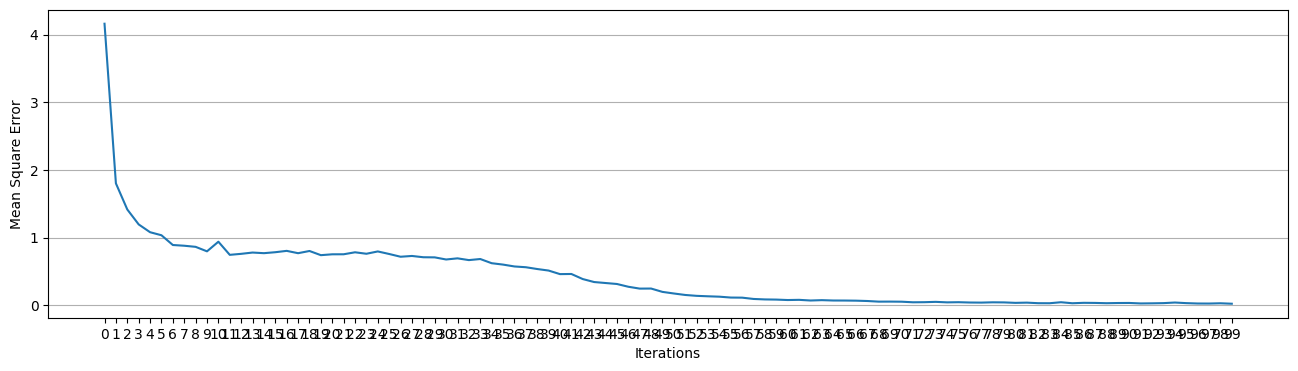

In [4]:
x = [x for x, y in training_process]
y = [y for x, y in training_process]
plt.figure(figsize=((16,4)))
plt.plot(x, y)
plt.xticks(x, x)
plt.xlabel("Iterations")
plt.ylabel("Mean Square Error")
plt.grid(axis="y")

$\color{red}{\text{Question-5:}}$ Plot the MSE versus iterations for $\alpha=1, \gamma=0.01$ and 100 iterations of SGD

$\color{red}{\text{Answer:}}$ Put your figure here

SGD Iteration: 10 ; error = 0.7251
SGD Iteration: 20 ; error = 0.3199
SGD Iteration: 30 ; error = 0.2523
SGD Iteration: 40 ; error = 0.2017
SGD Iteration: 50 ; error = 0.1609
SGD Iteration: 60 ; error = 0.1505
SGD Iteration: 70 ; error = 0.1173
SGD Iteration: 80 ; error = 0.1002
SGD Iteration: 90 ; error = 0.0861
SGD Iteration: 100 ; error = 0.0730


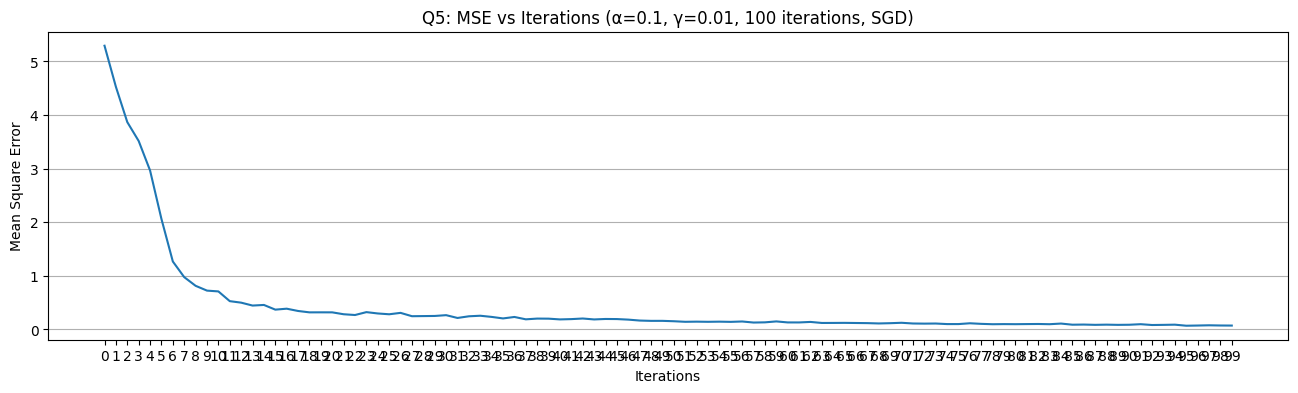

In [8]:
# Question 5: Plot MSE vs iterations for alpha=0.1, gamma=0.01, 100 iterations of SGD

R = np.array([
    [5, 3, 0, 1],
    [4, 0, 0, 1],
    [1, 1, 0, 5],
    [1, 0, 0, 4],
    [0, 1, 5, 4],
])

lf = LF(R, K=2, alpha=0.1, gamma=0.01, iterations=100)
training_process = lf.train()

x = [x for x, y in training_process]
y = [y for x, y in training_process]
plt.figure(figsize=(16, 4))
plt.plot(x, y)
plt.xticks(x, x)
plt.xlabel("Iterations")
plt.ylabel("Mean Square Error")
plt.title("Q5: MSE vs Iterations (α=0.1, γ=0.01, 100 iterations, SGD)")
plt.grid(axis="y")
plt.show()

### Expected Output Reference
Your plot should look similar to this:

![Expected MSE Plot](images/expected_mse_plot.png)

*(Note: The exact values might vary slightly due to random initialization)*


$\color{red}{\text{Question-6:}}$ Show the plot for 50 iterations, $\alpha=1, \gamma=0.01$ of SGD without bias, i.e., $b=0$

$\color{red}{\text{Answer:}}$ Paste your output and figures here or below this cell

SGD Iteration: 10 ; error = 0.9873
SGD Iteration: 20 ; error = 0.0730
SGD Iteration: 30 ; error = 0.0450
SGD Iteration: 40 ; error = 0.0286
SGD Iteration: 50 ; error = 0.0360

P x Q (without bias):
[[4.98160905 2.99931774 2.43711742 0.99933815]
 [3.99121611 2.42012092 2.19386692 1.00512566]
 [0.9941101  0.99919312 6.14043269 4.99097037]
 [0.99568846 0.91758524 4.97615197 4.00396564]
 [1.14080471 1.00045111 4.98356573 3.97919566]]



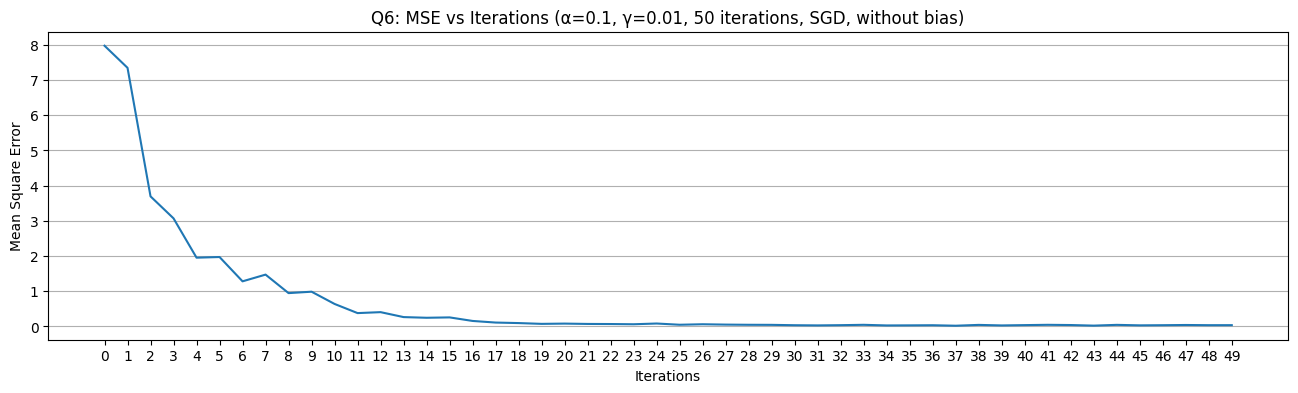

In [9]:
# Question 6: 50 iterations, alpha=0.1, gamma=0.01, SGD without bias (b=0)

R = np.array([
    [5, 3, 0, 1],
    [4, 0, 0, 1],
    [1, 1, 0, 5],
    [1, 0, 0, 4],
    [0, 1, 5, 4],
])

lf = LF(R, K=2, alpha=0.1, gamma=0.01, iterations=50, use_bias=False)
training_process = lf.train()

print()
print("P x Q (without bias):")
print(lf.full_matrix())
print()

x = [x for x, y in training_process]
y = [y for x, y in training_process]
plt.figure(figsize=(16, 4))
plt.plot(x, y)
plt.xticks(x, x)
plt.xlabel("Iterations")
plt.ylabel("Mean Square Error")
plt.title("Q6: MSE vs Iterations (α=0.1, γ=0.01, 50 iterations, SGD, without bias)")
plt.grid(axis="y")
plt.show()

$\color{red}{\text{Question-7:}}$ Repeat above with bias

$\color{red}{\text{Answer:}}$ Paste your output and figures here or below this cell

SGD Iteration: 10 ; error = 0.9994
SGD Iteration: 20 ; error = 0.4565
SGD Iteration: 30 ; error = 0.2567
SGD Iteration: 40 ; error = 0.1702
SGD Iteration: 50 ; error = 0.1172

P x Q (with bias):
[[5.0244021  3.03722292 3.34988986 1.01474586]
 [4.00015381 4.18169441 1.46105993 1.0543548 ]
 [1.06251972 1.02902389 4.30297609 5.0164538 ]
 [1.03352685 2.71565541 2.12635624 4.02826549]
 [2.59092836 0.9789076  4.99394443 3.96597151]]

Global bias: 2.769230769230769



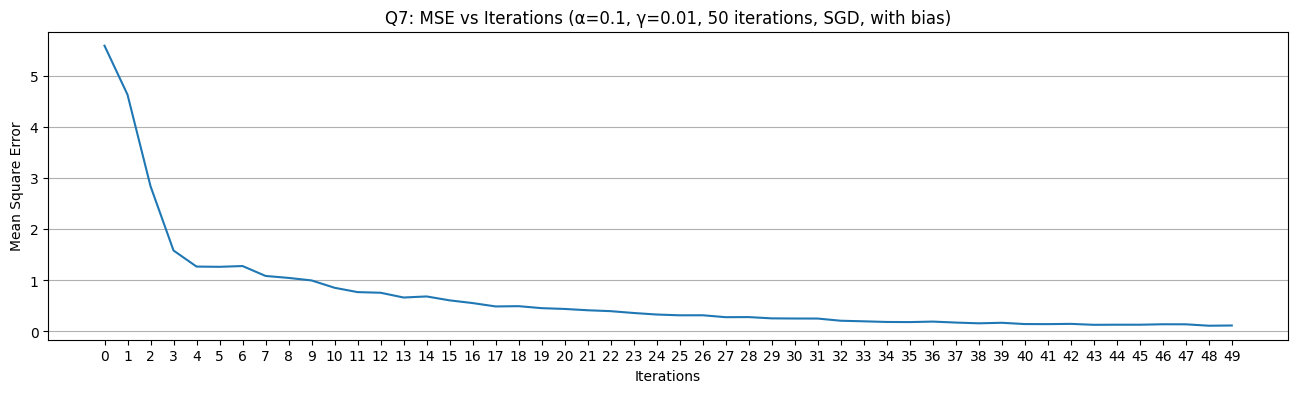

In [10]:
# Question 7: 50 iterations, alpha=0.1, gamma=0.01, SGD WITH bias

R = np.array([
    [5, 3, 0, 1],
    [4, 0, 0, 1],
    [1, 1, 0, 5],
    [1, 0, 0, 4],
    [0, 1, 5, 4],
])

lf = LF(R, K=2, alpha=0.1, gamma=0.01, iterations=50, use_bias=True)
training_process = lf.train()

print()
print("P x Q (with bias):")
print(lf.full_matrix())
print()
print("Global bias:", lf.b)
print()

x = [x for x, y in training_process]
y = [y for x, y in training_process]
plt.figure(figsize=(16, 4))
plt.plot(x, y)
plt.xticks(x, x)
plt.xlabel("Iterations")
plt.ylabel("Mean Square Error")
plt.title("Q7: MSE vs Iterations (α=0.1, γ=0.01, 50 iterations, SGD, with bias)")
plt.grid(axis="y")
plt.show()

$\color{red}{\text{Question-8:}}$ Show plots with values of regularization parameters to be 1, 0.1, 0.01, 0.001 and for 50 iterations, and $\alpha=1, \gamma=0.01$

$\color{red}{\text{Answer:}}$ Paste all your plots here or below this cell.

SGD Iteration: 10 ; error = 2.6214
SGD Iteration: 20 ; error = 2.2617
SGD Iteration: 30 ; error = 2.1156
SGD Iteration: 40 ; error = 2.4116
SGD Iteration: 50 ; error = 2.2000


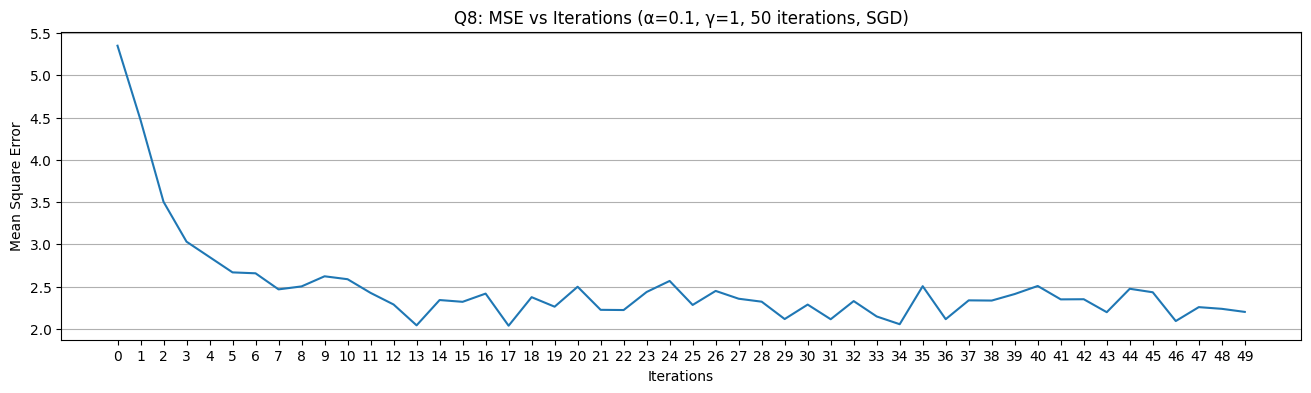


SGD Iteration: 10 ; error = 0.8032
SGD Iteration: 20 ; error = 0.3763
SGD Iteration: 30 ; error = 0.2754
SGD Iteration: 40 ; error = 0.2852
SGD Iteration: 50 ; error = 0.2830


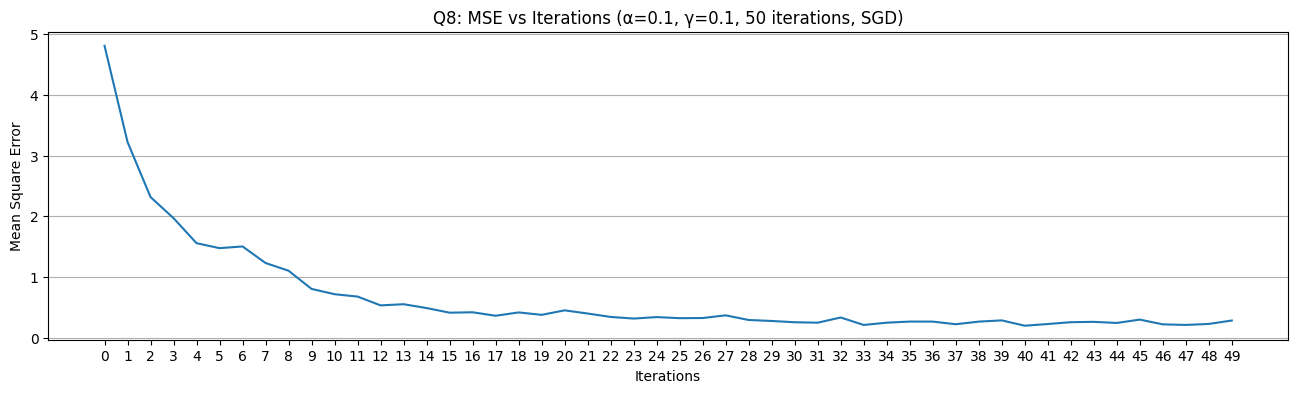


SGD Iteration: 10 ; error = 0.5643
SGD Iteration: 20 ; error = 0.2799
SGD Iteration: 30 ; error = 0.1895
SGD Iteration: 40 ; error = 0.1197
SGD Iteration: 50 ; error = 0.0841


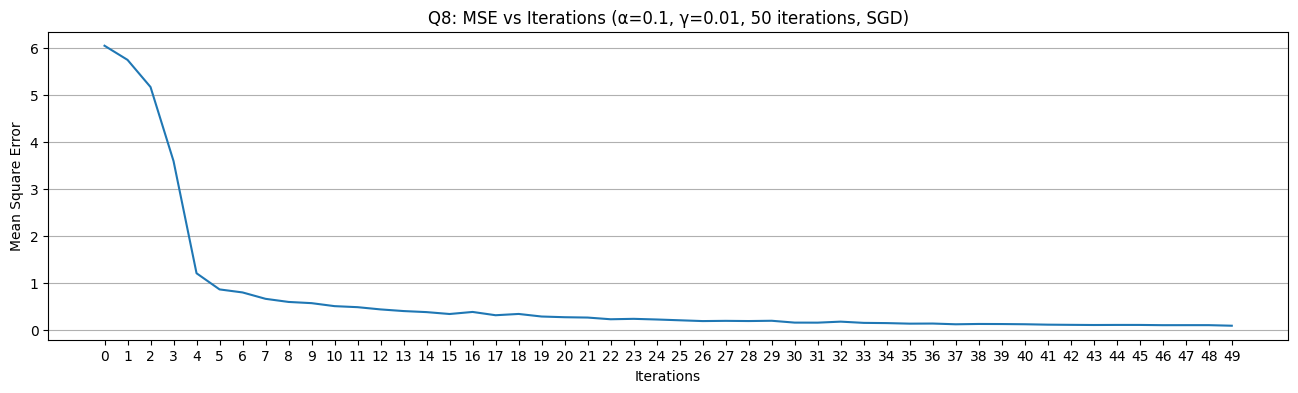


SGD Iteration: 10 ; error = 0.3091
SGD Iteration: 20 ; error = 0.1335
SGD Iteration: 30 ; error = 0.0708
SGD Iteration: 40 ; error = 0.0492
SGD Iteration: 50 ; error = 0.0320


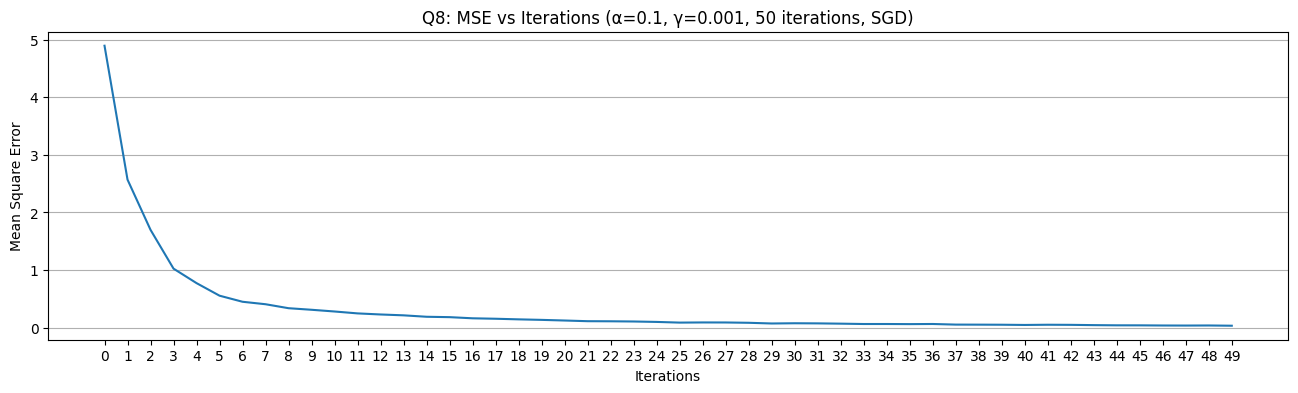

In [11]:
# Question 8: Show plots for gamma = 1, 0.1, 0.01, 0.001 with alpha=0.1, 50 iterations

R = np.array([
    [5, 3, 0, 1],
    [4, 0, 0, 1],
    [1, 1, 0, 5],
    [1, 0, 0, 4],
    [0, 1, 5, 4],
])

gamma_values = [1, 0.1, 0.01, 0.001]

for gamma_val in gamma_values:
    lf = LF(R, K=2, alpha=0.1, gamma=gamma_val, iterations=50, use_bias=True)
    training_process = lf.train()

    x = [x for x, y in training_process]
    y = [y for x, y in training_process]
    plt.figure(figsize=(16, 4))
    plt.plot(x, y)
    plt.xticks(x, x)
    plt.xlabel("Iterations")
    plt.ylabel("Mean Square Error")
    plt.title(f"Q8: MSE vs Iterations (α=0.1, γ={gamma_val}, 50 iterations, SGD)")
    plt.grid(axis="y")
    plt.show()
    print()

$\color{red}{\text{Question-9:}}$ Prove that the loss function is not convex. Is the loss function differentiable?

$\color{red}{\text{Answer:}}$

**Part 1: The loss function is NOT convex.**

The loss function is:
$$\mathcal{L}(\cdot) = \sum_{(i,j) \in \mathcal{K}} (r_{ij} - p_{i*}q_{*j})^2 + \frac{\gamma}{2} (\|P\|_F^2 + \|Q\|_F^2)$$

**Proof by counterexample:**

Consider a simple case with a single known rating $r_{11} = c$ and $k=1$, so $P = [p]$ and $Q = [q]$ are scalars. The loss function simplifies to:
$$\mathcal{L}(p, q) = (c - pq)^2 + \frac{\gamma}{2}(p^2 + q^2)$$

For a function to be convex, its Hessian matrix must be positive semi-definite everywhere.

The Hessian of $\mathcal{L}$ with respect to $(p, q)$ is:
$$H = \begin{bmatrix} \frac{\partial^2 \mathcal{L}}{\partial p^2} & \frac{\partial^2 \mathcal{L}}{\partial p \partial q} \\ \frac{\partial^2 \mathcal{L}}{\partial q \partial p} & \frac{\partial^2 \mathcal{L}}{\partial q^2} \end{bmatrix}$$

Computing the partial derivatives:
- $\frac{\partial \mathcal{L}}{\partial p} = -2(c - pq)q + \gamma p$
- $\frac{\partial^2 \mathcal{L}}{\partial p^2} = 2q^2 + \gamma$
- $\frac{\partial^2 \mathcal{L}}{\partial q^2} = 2p^2 + \gamma$
- $\frac{\partial^2 \mathcal{L}}{\partial p \partial q} = -2(c - pq)(-1) + (-2q)(p) \cdot (-1)$... Let us compute more carefully:

$\frac{\partial \mathcal{L}}{\partial p} = 2(pq - c)q + \gamma p$

$\frac{\partial^2 \mathcal{L}}{\partial p \partial q} = 2(pq - c) + 2pq + \gamma \cdot 0 = 2(2pq - c)$

So $H_{12} = H_{21} = 2(2pq - c)$.

The Hessian is:
$$H = \begin{bmatrix} 2q^2 + \gamma & 2(2pq - c) \\ 2(2pq - c) & 2p^2 + \gamma \end{bmatrix}$$

For $H$ to be positive semi-definite, we need $\det(H) \geq 0$:
$$\det(H) = (2q^2 + \gamma)(2p^2 + \gamma) - 4(2pq - c)^2$$

Choose $c = 0$, $p = q = M$ for large $M$, and small $\gamma$:
$$\det(H) = (2M^2 + \gamma)^2 - 4(2M^2)^2 = (2M^2 + \gamma)^2 - 16M^4$$

For large $M$: $(2M^2)^2 - 16M^4 = 4M^4 - 16M^4 = -12M^4 < 0$.

Since $\det(H) < 0$, the Hessian is **indefinite** (not positive semi-definite), which proves the loss function is **not convex**. $\square$

**Intuitive explanation:** The non-convexity arises from the bilinear term $p_{i*}q_{*j}$. The product of two variables is neither convex nor concave. Moreover, if $(P^*, Q^*)$ is a minimizer, then for any orthogonal matrix $O$, $(P^* O, O^T Q^*)$ gives the same objective value, creating multiple equivalent minima.

---

**Part 2: The loss function IS differentiable.**

Yes, the loss function is differentiable everywhere with respect to all parameters $p_{is}$ and $q_{sj}$.

- The squared error term $(r_{ij} - p_{i*}q_{*j})^2$ is a polynomial in the entries of $P$ and $Q$, hence infinitely differentiable.
- The regularization term $\frac{\gamma}{2}(\|P\|_F^2 + \|Q\|_F^2)$ is a sum of squares of the parameters, which is also infinitely differentiable.
- The sum of differentiable functions is differentiable.

Therefore, $\mathcal{L}$ is differentiable (in fact, $C^\infty$ smooth), and gradient-based methods (GD and SGD) are applicable.

## Bonus Question

$\color{red}{\text{Question-10:}}$ In the reference paper [1] above, additional bias terms are recommended, implement it

$\color{red}{\text{Answer:}}$ Put your modified function here or below this cell.

SGD Iteration: 10 ; error = 0.0262
SGD Iteration: 20 ; error = 0.0149
SGD Iteration: 30 ; error = 0.0164
SGD Iteration: 40 ; error = 0.0204
SGD Iteration: 50 ; error = 0.0155

P x Q (with global + user + item bias):
[[4.99529291 2.9991154  4.37237262 0.99692091]
 [3.99774826 1.96167085 4.27866157 1.00210087]
 [1.0016221  1.00155995 3.37808542 4.99211772]
 [1.00363268 0.35851006 3.72402889 3.99630575]
 [2.23642672 1.00703543 4.99455072 3.99509671]]

Global bias (mu): 2.769230769230769
User biases (b_u): [ 0.32872294 -0.17495716 -0.01722523 -0.42174244  0.28182586]
Item biases (b_i): [-0.23481617 -1.26069406  1.21074662  0.38646961]



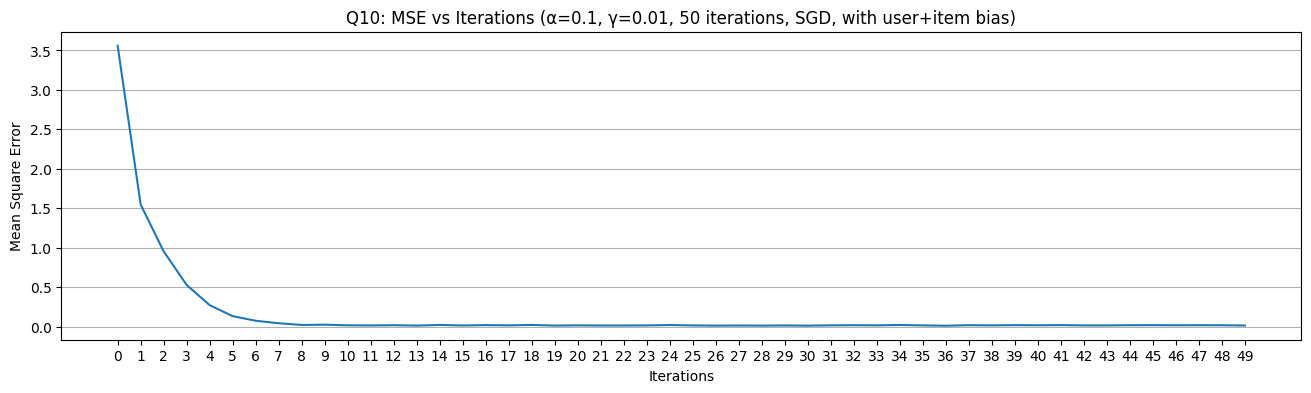

In [12]:
# Question 10: Implement additional bias terms (user bias b_u and item bias b_i)
# as recommended in Koren, Bell, Volinsky [1]
# Prediction: r_hat_ij = mu + b_u[i] + b_i[j] + p_i * q_j

R = np.array([
    [5, 3, 0, 1],
    [4, 0, 0, 1],
    [1, 1, 0, 5],
    [1, 0, 0, 4],
    [0, 1, 5, 4],
])

lf = LF(R, K=2, alpha=0.1, gamma=0.01, iterations=50, use_bias=True, use_user_item_bias=True)
training_process = lf.train()

print()
print("P x Q (with global + user + item bias):")
print(lf.full_matrix())
print()
print("Global bias (mu):", lf.b)
print("User biases (b_u):", lf.b_u)
print("Item biases (b_i):", lf.b_i)
print()

x = [x for x, y in training_process]
y = [y for x, y in training_process]
plt.figure(figsize=(16, 4))
plt.plot(x, y)
plt.xticks(x, x)
plt.xlabel("Iterations")
plt.ylabel("Mean Square Error")
plt.title("Q10: MSE vs Iterations (α=0.1, γ=0.01, 50 iterations, SGD, with user+item bias)")
plt.grid(axis="y")
plt.show()

$\color{red}{\text{Question-11 (Bonus):}}$ Run your algorithm on the MovieLens 100k dataset.

Since the Netflix prize dataset is large and requires permission, we will use the **MovieLens 100k** dataset as a standard proxy.

1. Download the dataset from [GroupLens](https://grouplens.org/datasets/movielens/latest/).
2. Parse the `ratings.csv` file.
3. Run your `LF` model on it.

You can use the following helper code to download and load the data:

Download complete!
Loaded 100836 ratings
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931
Number of users: 610, Number of items: 9724
Download complete!
Loaded 100836 ratings
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931
Number of users: 610, Number of items: 9724
SGD Iteration: 10 ; error = 239.3588
SGD Iteration: 10 ; error = 239.3588
SGD Iteration: 20 ; error = 237.5610
SGD Iteration: 20 ; error = 237.5610


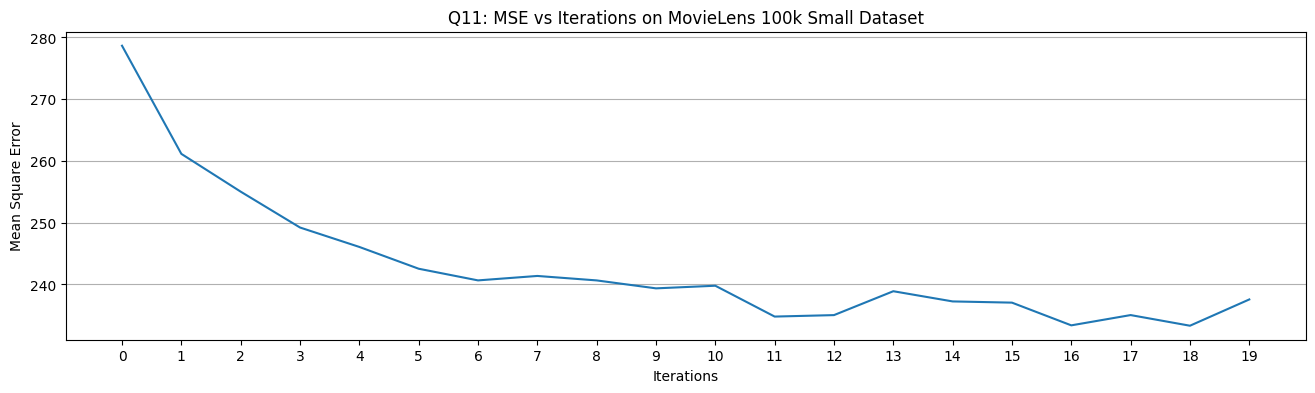

In [13]:
import requests, zipfile, os, io, pandas as pd

def download_movielens(url='https://files.grouplens.org/datasets/movielens/ml-latest-small.zip',
                       dest_dir='ml-latest-small'):
    """Download and extract the MovieLens latest-small dataset."""
    if not os.path.exists(dest_dir):
        print("Downloading MovieLens dataset...")
        r = requests.get(url)
        z = zipfile.ZipFile(io.BytesIO(r.content))
        z.extractall('.')
        print("Download complete!")
    else:
        print("Dataset already downloaded.")
    return dest_dir

def load_ratings(dest_dir='ml-latest-small'):
    """Load ratings.csv and create user-item rating matrix R."""
    ratings_path = os.path.join(dest_dir, 'ratings.csv')
    ratings_data = pd.read_csv(ratings_path)
    print(f"Loaded {len(ratings_data)} ratings")
    print(ratings_data.head())

    # Create user and movie ID mappings (to 0-based indices)
    user_ids = sorted(ratings_data['userId'].unique())
    movie_ids = sorted(ratings_data['movieId'].unique())

    user_to_idx = {uid: idx for idx, uid in enumerate(user_ids)}
    movie_to_idx = {mid: idx for idx, mid in enumerate(movie_ids)}

    num_users = len(user_ids)
    num_items = len(movie_ids)

    print(f"Number of users: {num_users}, Number of items: {num_items}")

    # Initialize the rating matrix with zeros (0 = unknown)
    R = np.zeros((num_users, num_items))

    for row in ratings_data.itertuples():
        user_idx = user_to_idx[row.userId]
        movie_idx = movie_to_idx[row.movieId]
        R[user_idx, movie_idx] = row.rating

    return R

# Download and load data
dest_dir = download_movielens()
R_movielens = load_ratings(dest_dir)

# Run LF model on MovieLens data
lf = LF(R_movielens, K=10, alpha=0.1, gamma=0.1, iterations=20, use_bias=True, use_user_item_bias=True)
training_process = lf.train()

x = [x for x, y in training_process]
y = [y for x, y in training_process]
plt.figure(figsize=(16, 4))
plt.plot(x, y)
plt.xticks(x, x)
plt.xlabel("Iterations")
plt.ylabel("Mean Square Error")
plt.title("Q11: MSE vs Iterations on MovieLens 100k Small Dataset")
plt.grid(axis="y")
plt.show()

### Expected Output Reference (MovieLens)
On the MovieLens small dataset, your error curve should look something like this:

![Expected MovieLens Plot](images/expected_movielens_plot.png)


## Thats All Folks! Further Readings or Infomation 
https://www.coursera.org/learn/networks-illustrated/lecture/8GPZT/netflix-timeline

# Keep Recommending!